In [49]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm.notebook import tqdm
import numpy as np
from torchvision import datasets
from torchvision import transforms as T
from torch.optim import Adam, SGD
import h5py as h5
import torch.nn.functional as F
import random
from torchsummary import summary

%matplotlib inline

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cpu')

#### Reading data

In [27]:
train_data = h5.File("Signs_Data_Training.h5", "r")

In [28]:
test_data = h5.File("Signs_Data_Testing.h5", "r")

In [29]:
train_data.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [30]:
classes, train_X, train_Y = list(train_data["list_classes"]), \
                            np.array(train_data["train_set_x"]), \
                            np.array(train_data["train_set_y"])

In [31]:
test_X, test_Y = np.array(test_data["test_set_x"]), \
                 np.array(test_data["test_set_y"])

In [32]:
classes

[0, 1, 2, 3, 4, 5]

In [33]:
train_X.shape

(1080, 64, 64, 3)

In [34]:
train_Y.shape

(1080,)

#### Visualization

In [35]:
r_images = [random.randint(0, 1000) for _ in range(9)]

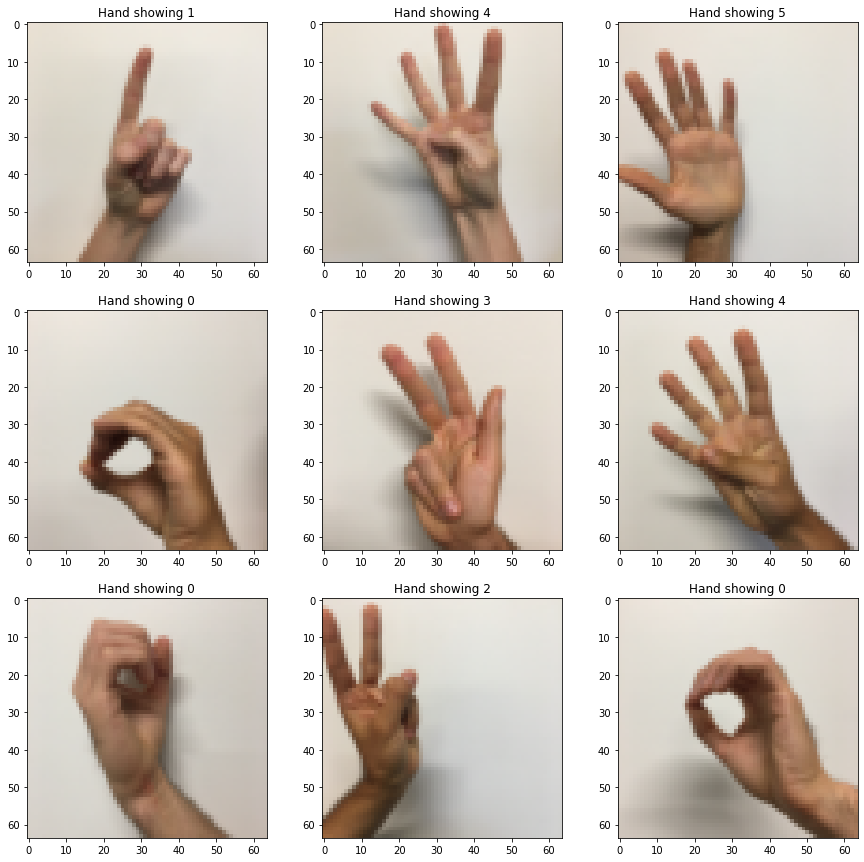

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
c = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(train_X[r_images[c]])
        axes[i, j].set_title("Hand showing {}".format(train_Y[r_images[c]]))
        c += 1

#### Utils classes

In [95]:
class HandDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if transform:
            return transform(self.x[idx]), self.y[idx]
        return self.x[idx], self.y[idx]

In [129]:
transform = T.Compose([
    T.ToPILImage(),
    T.Grayscale(),
    T.ToTensor(),
])

In [130]:
train_ds = HandDataset(train_X, train_Y, transform)

In [131]:
test_ds = HandDataset(test_X, test_Y, transform)

In [133]:
train_ds[0][0].shape

torch.Size([1, 64, 64])